# Evaluating Bot Performance (Chess)

In [1]:
import os
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

parent = '/'.join(s for s in os.getcwd().split('/')[:-1])
print(parent)

/Users/benbellerose/Documents/GitHub/chappie.ai


In [2]:
import pandas as pd

ai = 'test_V3'

game_df = pd.read_csv(f'{parent}/skills/chess/data/models/{ai}/logs/game_log.csv')
game_df.head(5)

,state0,state1,state2,state3,state4,state5,state6,state7,state8,state9,...,prob4092,prob4093,prob4094,prob4095,action,value,reward,ELO,Game-ID,Date
0,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,0.0,3690.0,0.0,0.0,NaN,Q4XOB101RO3DA3M,2022-02-07 18:07:29.725793
1,1.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,0.0,861.0,0.0,0.0,NaN,Q4XOB101RO3DA3M,2022-02-07 18:07:29.725793
2,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,0.0,3364.0,0.0,0.0,NaN,Q4XOB101RO3DA3M,2022-02-07 18:07:29.725793
3,1.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,0.0,731.0,0.0,0.0,NaN,Q4XOB101RO3DA3M,2022-02-07 18:07:29.725793
4,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,0.0,3437.0,0.0,0.0,NaN,Q4XOB101RO3DA3M,2022-02-07 18:07:29.725793


## Game Play

In [3]:
def parse_move(move):
    x_map = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #Board x representation
    y_map = ['8', '7', '6', '5', '4', '3', '2', '1'] #Board y representation
    b_a = int(move['action'])
    a_map = np.zeros(4096)
    a_map[b_a] = 1
    a_map = a_map.reshape((8,8,8,8))
    a_index = [(cy, cx, ny, nx) for cy, cx, ny, nx in zip(*np.where(a_map == 1))][0]
    c_p = f'{x_map[a_index[1]]}{y_map[a_index[0]]}'
    n_p = f'{x_map[a_index[3]]}{y_map[a_index[2]]}'
    return (c_p, n_p)

### Win Distribution

Knowing the win distrabution helps know how balanced our training data is being.

In [4]:
results = []
for g, g_df in game_df.groupby('Game-ID'):
    results.append({'game':g, 'result':g_df.iloc[0]['value'], 'duration':len(g_df)})
results = pd.DataFrame(results)
print(f'Total Games Played = {len(results)}')
results['result'].value_counts(normalize=True).to_frame().T

Total Games Played = 222


,-1.0,1.0,0.0
result,0.427928,0.400901,0.171171


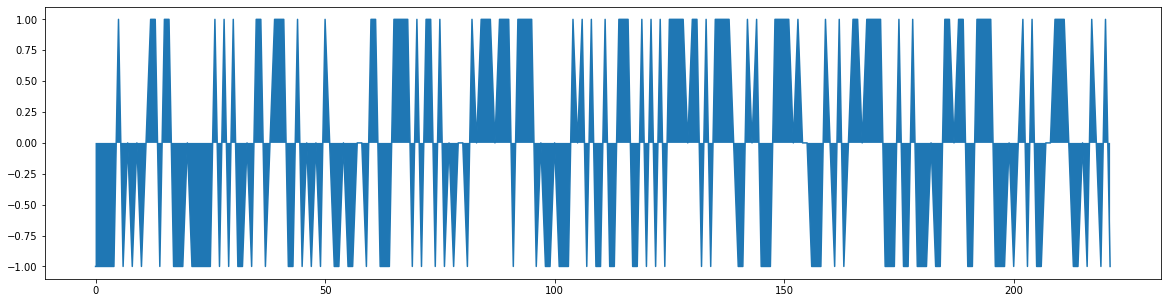

In [5]:
results['result'].plot.line(figsize=(20, 5), legend=False)
plt.fill_between(results.index,results['result'])
plt.show()

### Game Duration

<AxesSubplot:>

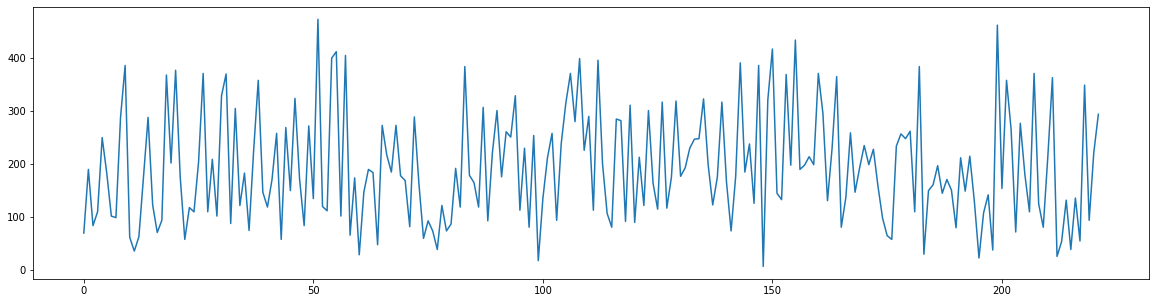

In [6]:
results['duration'].plot.line(figsize=(20, 5), legend=False)

### Move Distribution

In [7]:
x_map = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #Board x representation
y_map = ['8', '7', '6', '5', '4', '3', '2', '1'] #Board y representation

o_results = []
for g, g_log in game_df.groupby('Game-ID'):
    move = 1
    for i, row in g_log.iterrows():
        c_pos, n_pos = parse_move(row)
        o_results.append({
            'x': x_map.index(n_pos[0]), 
            'y':y_map.index(n_pos[1]),
            'z':move, 
            'c':-1 if (move % 2) == 0 else 1
        })
        move += 1
o_results = pd.DataFrame(o_results)

### White Player Move Distribution

In [8]:
w_results = o_results[o_results['c']==1]
w_m_count_df = []
for m, m_df in w_results.groupby('z'):
    m_hold = {}
    for i, row in m_df.iterrows():
        board = np.zeros((8,8))
        board[row['y']][row['x']] = 1
        board = board.reshape((64))
        flat_pos = np.where(board == 1)[0][0]
        if flat_pos in m_hold:
            m_hold[flat_pos] += 1
        else:
            m_hold[flat_pos] = 1
    for x in range(64):
        w_m_count_df.append({
            'x':x,
            'y':m,
            'z':m_hold[x] if x in m_hold else 0
        })
    
w_m_count_df = pd.DataFrame(w_m_count_df).fillna(0)

Text(0.5, 0, 'action occurrence')

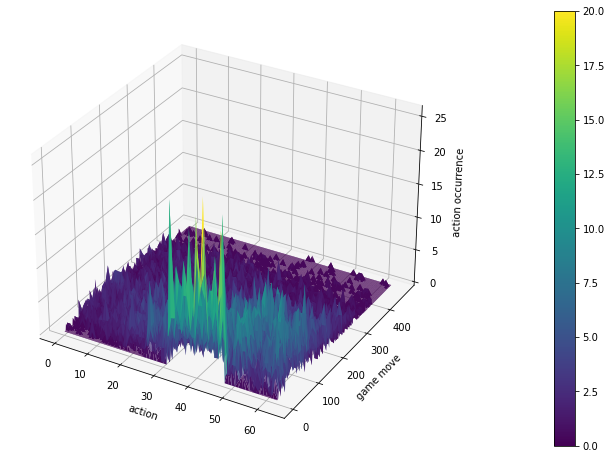

In [9]:
plt.rcParams['figure.figsize'] = (40,8)

ax = plt.axes(projection='3d')
plot3D = ax.plot_trisurf(w_m_count_df['x'], w_m_count_df['y'], w_m_count_df['z'], cmap='viridis', linewidth=0.5)

cb = plt.colorbar(plot3D)

ax.set_xlabel('action')
ax.set_ylabel('game move')
ax.set_zlabel('action occurrence')

### Black Player Move Distribution

In [10]:
b_results = o_results[o_results['c']==-1]
b_m_count_df = []
for m, m_df in b_results.groupby('z'):
    m_hold = {}
    for i, row in m_df.iterrows():
        board = np.zeros((8,8))
        board[row['y']][row['x']] = 1
        board = board.reshape((64))
        flat_pos = np.where(board == 1)[0][0]
        if flat_pos in m_hold:
            m_hold[flat_pos] += 1
        else:
            m_hold[flat_pos] = 1
    for x in range(64):
        b_m_count_df.append({
            'x':x,
            'y':m,
            'z':m_hold[x] if x in m_hold else 0
        })
    
b_m_count_df = pd.DataFrame(b_m_count_df).fillna(0)

Text(0.5, 0, 'action occurrence')

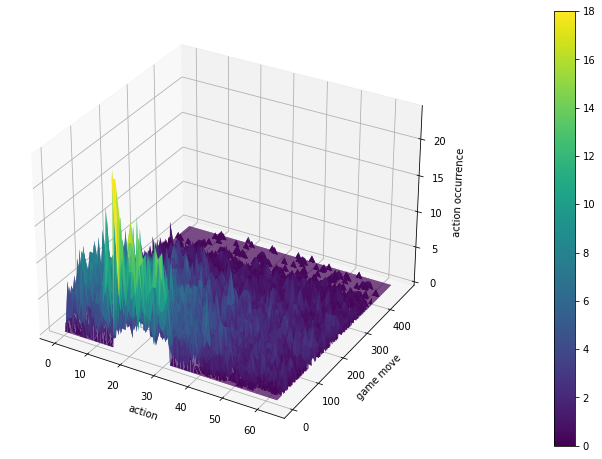

In [11]:
plt.rcParams['figure.figsize'] = (40,8)

ax = plt.axes(projection='3d')
plot3D = ax.plot_trisurf(b_m_count_df['x'], b_m_count_df['y'], b_m_count_df['z'], cmap='viridis', linewidth=0.5)

cb = plt.colorbar(plot3D)

ax.set_xlabel('action')
ax.set_ylabel('game move')
ax.set_zlabel('action occurrence')

### White Opening Moves

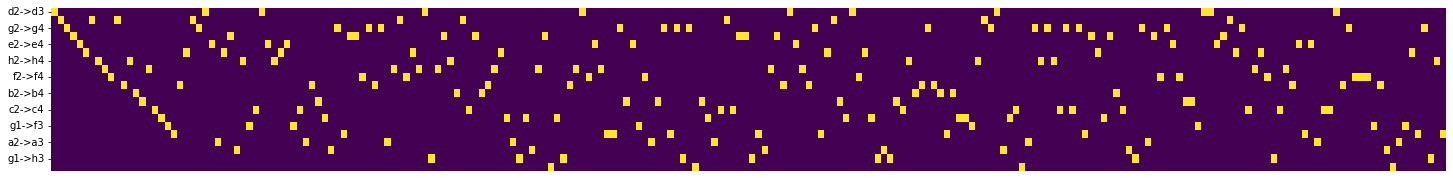

In [12]:
o_results = []
for g, g_log in game_df.groupby('Game-ID'):
    c_pos, n_pos = parse_move(g_log.iloc[0])
    o_results.append({f'{c_pos}->{n_pos}':1})
o_results = pd.DataFrame(o_results).fillna(0).T

plt.rcParams['figure.figsize'] = [25, 3] #Resize graph 
sb.heatmap(o_results, cmap='viridis', cbar=False, xticklabels=False, linewidths=0)
plt.show()

### Black Opening Moves

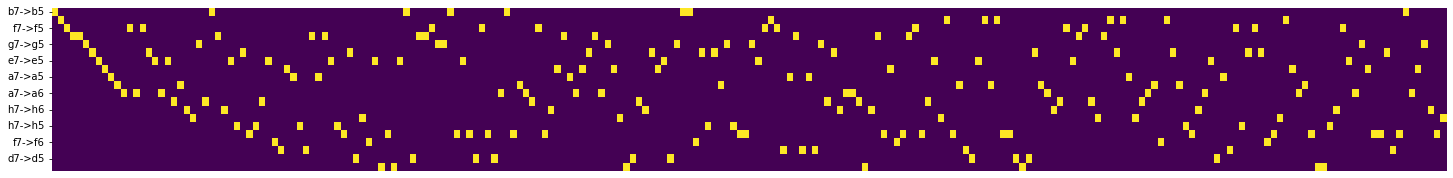

In [13]:
o_results = []
for g, g_log in game_df.groupby('Game-ID'):
    c_pos, n_pos = parse_move(g_log.iloc[1])
    o_results.append({f'{c_pos}->{n_pos}':1})
o_results = pd.DataFrame(o_results).fillna(0).T

plt.rcParams['figure.figsize'] = [25, 3] #Resize graph 
sb.heatmap(o_results, cmap='viridis', cbar=False, xticklabels=False, linewidths=0)
plt.show()

### Game Action Probabilities

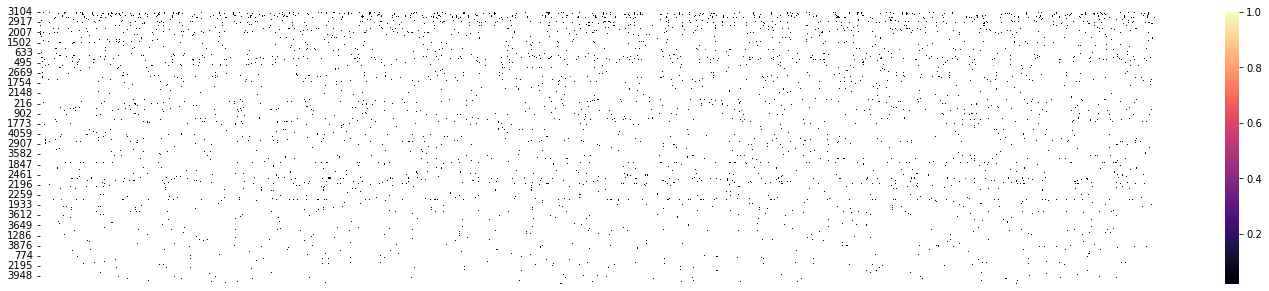

In [14]:
p_headers = [h for h in game_df if 'prob' in h]

a_probs = []
for i, row in game_df[p_headers].iterrows():
    a_probs.append({k.replace('prob',''):v for k, v in row[(row > 0)].to_dict().items()})

a_probs = pd.DataFrame(a_probs)
plt.rcParams['figure.figsize'] = [25, 5] #Resize graph 
sb.heatmap(a_probs.T, cmap='magma', xticklabels=False, linewidths=0)
plt.show()

### Game Tree

In [15]:
'''
s_headers = [h for h in game_df if 'state' in h]
p_headers = [h for h in game_df if 'prob' in h]

tree = {}
for i, row in game_df.iterrows():
    s_hash = hash(str(row[s_headers].tolist()))
    tree[(s_hash)] = 
    break
print(tree)


import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

G = nx.Graph()
for s in search.tree:
    for a in search.tree[s].n_s:
        G.add_edge(s,a)
        
pos = graphviz_layout(G, prog='dot')
#Display network graph -----------------------------
nx.draw(
    G, #Graph nodes & connections
    pos, #Position of graph
    with_labels=True #Labels on nodes
)
plt.rcParams['figure.figsize'] = [40, 40] #Resize graph
plt.show()
'''

"\ns_headers = [h for h in game_df if 'state' in h]\np_headers = [h for h in game_df if 'prob' in h]\n\ntree = {}\nfor i, row in game_df.iterrows():\n    s_hash = hash(str(row[s_headers].tolist()))\n    tree[(s_hash)] = \n    break\nprint(tree)\n\n\nimport matplotlib.pyplot as plt\nimport networkx as nx\nimport pydot\nfrom networkx.drawing.nx_pydot import graphviz_layout\n\nG = nx.Graph()\nfor s in search.tree:\n    for a in search.tree[s].n_s:\n        G.add_edge(s,a)\n        \npos = graphviz_layout(G, prog='dot')\n#Display network graph -----------------------------\nnx.draw(\n    G, #Graph nodes & connections\n    pos, #Position of graph\n    with_labels=True #Labels on nodes\n)\nplt.rcParams['figure.figsize'] = [40, 40] #Resize graph\nplt.show()\n"

### ELO Rating

<AxesSubplot:>

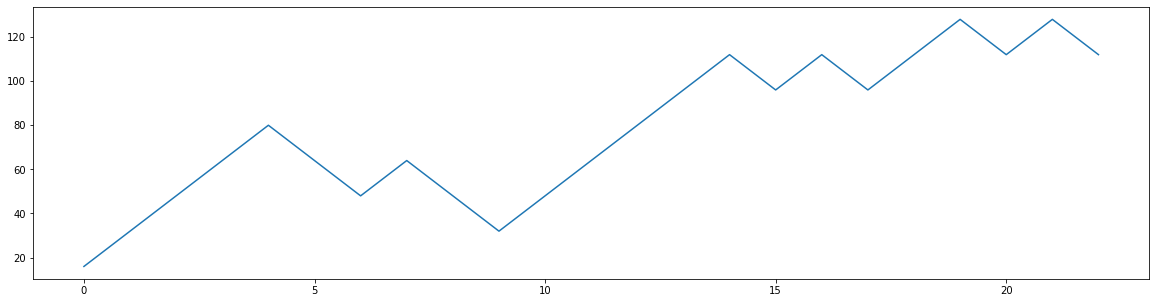

In [16]:
elo_df = game_df.drop_duplicates(subset=['Game-ID']).dropna().reset_index()
elo_df['ELO'].dropna().plot.line(figsize=(20, 5), legend=False)

## Training Results

In [17]:
model_list = [m for m in os.listdir(f'{parent}/skills/chess/data/models') if m != '.DS_Store' and '(temp)' not in m]

training_df = pd.DataFrame()
for ai in model_list:
    training_df = training_df.append(pd.read_csv(f'{parent}/skills/chess/data/models/{ai}/logs/training_log.csv'), ignore_index=False)
training_df = pd.DataFrame(training_df)
training_df = training_df.replace(0, np.nan)
training_df['Epoch'] = training_df['Epoch'].fillna(0)
training_df.head(5)

,Date,Epoch,Samples,Time,hidden loss,backbone loss,value loss,policy loss,state loss,reward loss,model,Cca loss
0,2021-12-17 17:44:45.782927,0.0,131,2.861142,1.140343,2.662142,1.040456,0.002289,1.494196,0.032864,skills/chess/data/models/test,NaN
1,2021-12-17 17:44:48.579630,1.0,131,5.657838,1.010303,2.531318,1.010154,0.002264,1.521493,0.013217,skills/chess/data/models/test,NaN
2,2021-12-17 17:44:51.375180,2.0,131,8.453389,0.967158,2.457381,1.001177,0.002247,1.458859,0.007631,skills/chess/data/models/test,NaN
3,2021-12-17 17:44:54.172715,3.0,131,11.250923,0.915422,2.397455,0.904644,0.002222,1.487822,0.004810,skills/chess/data/models/test,NaN
4,2021-12-17 17:44:56.971183,4.0,131,14.049468,0.912614,2.399837,0.960183,0.002200,1.509865,0.003382,skills/chess/data/models/test,NaN


In [39]:
from IPython.display import display

for m, m_df in training_df.groupby('model'):
    print(m)
    display(m_df.describe())

skills/chess/data/models/test


,Epoch,Samples,Time,hidden loss,backbone loss,value loss,policy loss,state loss,reward loss,Cca loss
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,1.800000e+02,0.0
mean,4.500000,130.333333,15.131659,0.911087,3.163255,0.880133,0.002207,2.254773,1.549308e-02,NaN
std,2.880293,78.907343,12.936464,0.124174,0.995025,0.084858,0.000062,0.990829,2.346951e-02,NaN
min,0.000000,17.000000,0.498023,0.749941,1.283093,0.659761,0.002061,0.454605,1.108192e-07,NaN
25%,2.000000,60.000000,5.005207,0.831334,2.519134,0.814412,0.002164,1.582180,1.018559e-03,NaN
50%,4.500000,119.000000,11.114186,0.875651,2.938040,0.861863,0.002218,2.063481,5.115632e-03,NaN
75%,7.000000,192.000000,22.256495,0.962482,3.704700,0.930839,0.002257,2.841366,2.181831e-02,NaN
max,9.000000,275.000000,59.558535,1.447875,5.665066,1.153145,0.002305,4.693615,1.398770e-01,NaN


skills/chess/data/models/test_V2


,Epoch,Samples,Time,hidden loss,backbone loss,value loss,policy loss,state loss,reward loss,Cca loss
count,2410.000000,2410.000000,2410.000000,1554.000000,1554.000000,2410.000000,2410.000000,2410.000000,2410.000000,0.0
mean,4.500000,265.251867,284.532074,0.954296,2.907931,0.950960,0.002272,1.961915,0.034709,NaN
std,2.872877,1589.282212,2137.367537,0.234297,0.839477,0.251232,0.000010,0.814789,0.035697,NaN
min,0.000000,35.000000,0.393126,0.018083,1.180199,0.008005,0.002245,0.597554,0.004967,NaN
25%,2.000000,116.000000,7.586785,0.972141,2.295197,0.966195,0.002266,1.335511,0.015580,NaN
50%,4.500000,196.000000,16.227599,1.004405,2.688482,0.999563,0.002271,1.813817,0.022821,NaN
75%,7.000000,265.000000,33.877286,1.029325,3.530457,1.040908,0.002276,2.482614,0.038897,NaN
max,9.000000,43958.000000,22357.099421,1.454478,6.600495,1.722842,0.002300,6.007566,0.324419,NaN


skills/chess/data/models/test_V3


,Epoch,Samples,Time,hidden loss,backbone loss,value loss,policy loss,state loss,reward loss,Cca loss
count,1980.000000,1980.000000,1980.000000,8.000000,8.000000,1980.000000,1980.000000,1980.000000,1980.000000,0.0
mean,4.500000,284.652525,148.392781,0.918581,3.033218,1.003208,0.002290,2.007359,0.113322,NaN
std,2.873007,1410.603503,1012.156112,0.080916,0.758476,0.335150,0.000004,0.742286,0.087260,NaN
min,0.000000,7.000000,0.093187,0.762776,2.029454,0.026196,0.002277,0.519199,0.004890,NaN
25%,2.000000,120.000000,3.741938,0.892876,2.569028,1.042713,0.002288,1.502356,0.054666,NaN
50%,4.500000,192.000000,7.580525,0.922318,3.034435,1.080997,0.002290,1.926939,0.086189,NaN
75%,7.000000,280.500000,13.532888,0.960646,3.373411,1.134327,0.002293,2.386445,0.147649,NaN
max,9.000000,38278.000000,10666.682258,1.038173,4.149980,1.702780,0.002306,5.114865,0.789817,NaN


### Hidden Layer Loss

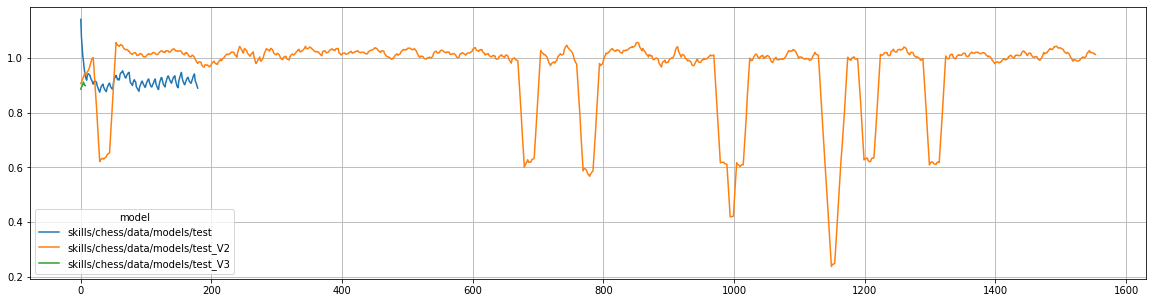

In [18]:
if 'hidden loss' in training_df:
    h_df = training_df[['hidden loss','model']].dropna().reset_index()
    h_df['hidden loss'] = h_df['hidden loss'].rolling(window=25, min_periods=1).mean()
    if len(h_df) > 0 and 'model' in h_df:
        h_df = h_df.groupby('model')['hidden loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        h_df[[h for h in h_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Backbone Layer Loss

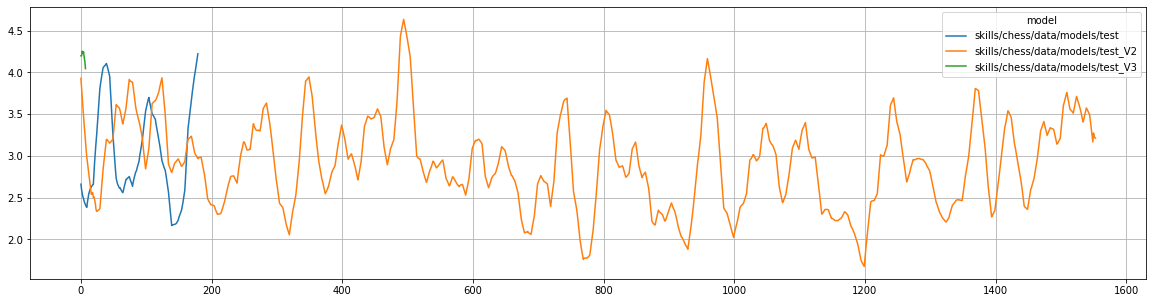

In [19]:
if 'backbone loss' in training_df:
    b_df = training_df[['backbone loss','model']].dropna().reset_index()
    b_df['backbone loss'] = b_df['backbone loss'].rolling(window=25, min_periods=1).mean()
    if len(b_df) > 0 and 'model' in b_df:
        b_df = b_df.groupby('model')['backbone loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        b_df[[h for h in b_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Chunked Cross Attention Layer Loss

In [20]:
if 'Cca loss' in training_df:
    cca_df = training_df[['Cca loss','model']].dropna().reset_index()
    cca_df['Cca loss'] = cca_df['Cca loss'].rolling(window=25, min_periods=1).mean()
    if len(cca_df) > 0 and 'model' in cca_df:
        cca_df = h_df.groupby('model')['Cca loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        cca_df[[h for h in cca_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Value Head Loss

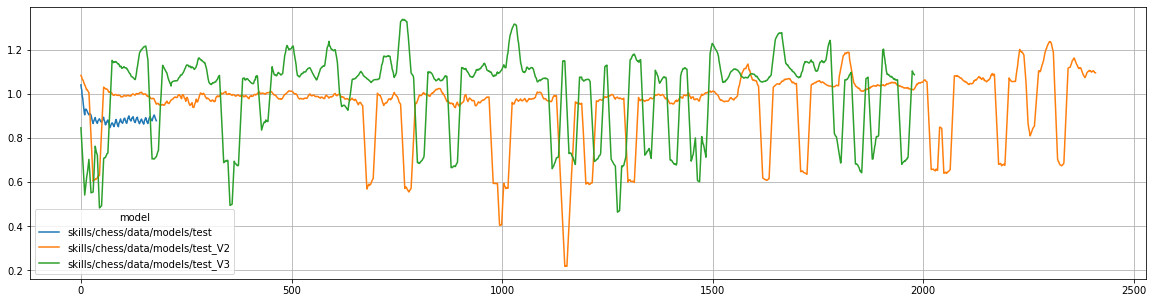

In [21]:
if 'value loss' in training_df:
    v_df = training_df[['value loss','model']].dropna().reset_index()
    v_df['value loss'] = v_df['value loss'].rolling(window=25, min_periods=1).mean()
    if len(v_df) > 0 and 'model' in v_df:
        v_df = v_df.groupby('model')['value loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        v_df[[h for h in v_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Policy Head Loss

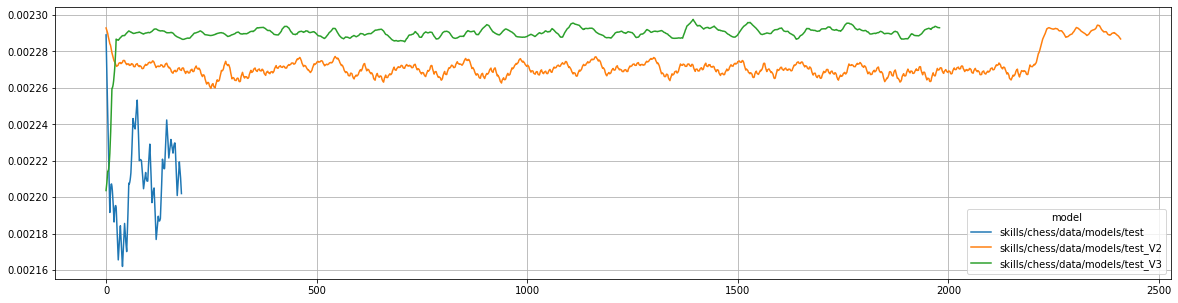

In [22]:
if 'policy loss' in training_df:
    p_df = training_df[['policy loss','model']].dropna().reset_index()
    p_df['policy loss'] = p_df['policy loss'].dropna().rolling(window=25, min_periods=1).mean()
    if len(p_df) > 0 and 'model' in p_df:
        p_df = p_df.groupby('model')['policy loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        p_df[[h for h in h_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Next State Head Loss

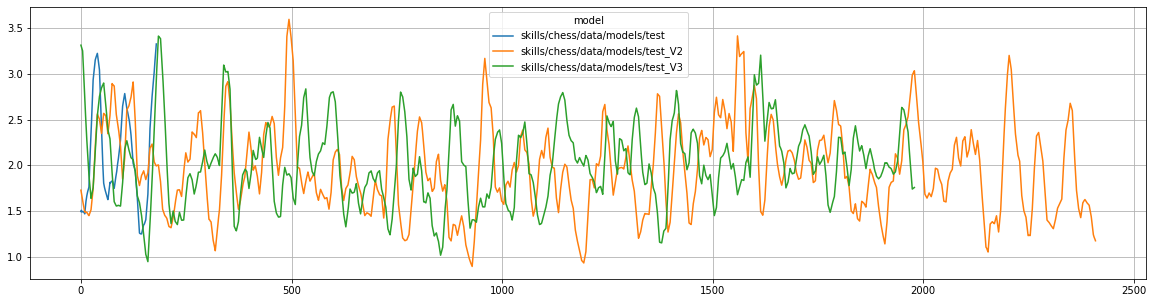

In [23]:
if 'state loss' in training_df:
    s_df = training_df[['state loss','model']].dropna().reset_index()
    s_df['state loss'] = s_df['state loss'].dropna().rolling(window=25, min_periods=1).mean()
    if len(s_df) > 0 and 'model' in s_df:
        s_df = s_df.groupby('model')['state loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        s_df[[h for h in s_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Reward Head Loss

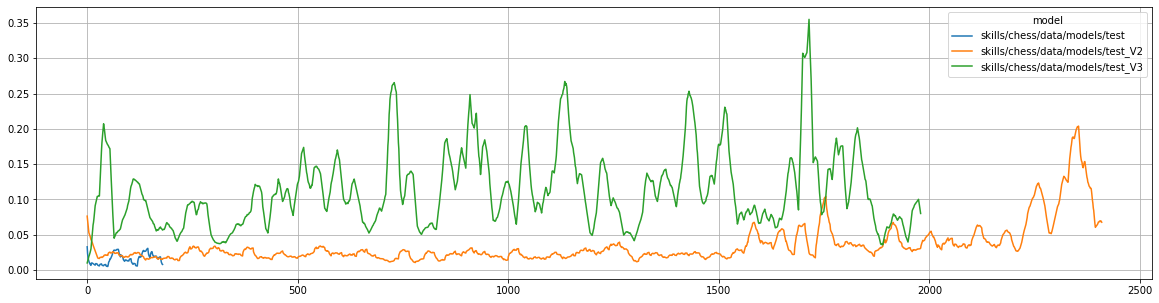

In [24]:
if 'reward loss' in training_df:
    r_df = training_df[['reward loss','model']].dropna().reset_index()
    r_df['reward loss'] = r_df['reward loss'].dropna().rolling(window=25, min_periods=1).mean()
    if len(r_df) > 0 and 'model' in r_df:
        r_df = r_df.groupby('model')['reward loss'].apply(lambda x: pd.Series(x.values)).unstack().T.reset_index()
        r_df[[h for h in r_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)